# Summary
This notebook summarises all the analyses and visualisations done to understand various relationships in the internal and external datasets.

### Imports and Pyspark session

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, sys, ssl
from functools import reduce
import string, re

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
sys.path

['/home/ruitwang/generic-buy-now-pay-later-project-group-3/notebooks',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/ruitwang/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/home/ruitwang/.ipython']

In [5]:
sys.path.append("/home/ruitwang/generic-buy-now-pay-later-project-group-3/scripts/")

import utils

In [6]:
sp = SparkSession.builder.appName("Summary").getOrCreate()

22/10/06 11:28:52 WARN Utils: Your hostname, Loky-PC resolves to a loopback address: 127.0.1.1; using 192.168.55.225 instead (on interface eth0)
22/10/06 11:28:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/06 11:28:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/06 11:29:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/06 11:29:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Read all relevant files

In [9]:
# from scripts.utils import read_tables

transactions = utils.read_tables(sp, "transactions")
customers = utils.read_tables(sp, "tbl_consumer")
consumer_user_details = utils.read_tables(sp, "consumer_user_details")
merchants = utils.read_tables(sp, "tbl_merchants")

cFraud = utils.read_tables(sp, "consumer_fraud_probability", "c")
mFraud = utils.read_tables(sp, "merchant_fraud_probability", "c")

In [10]:
# We only need the 'user_id' for customer, 'consumer_id' not required
customers = customers.join(consumer_user_details, ['consumer_id']).drop('consumer_id')

### Checking Dollar values by date

In [11]:
amount_per_day = transactions.groupBy("order_datetime").sum("dollar_value").toPandas()

In [12]:
amount_per_day.columns = ["order dates", "transaction amount"]
amount_per_day["order dates"] = pd.to_datetime(amount_per_day["order dates"])
amount_per_day.sort_values(by="order dates", inplace=True)

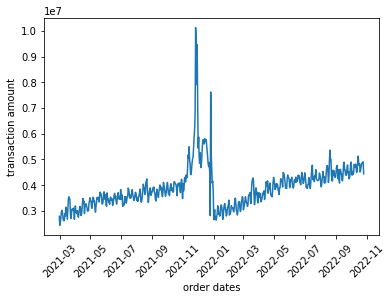

In [13]:
sns.lineplot(x="order dates", y="transaction amount", data=amount_per_day)
plt.xticks(rotation=45)
plt.show()

There is a clear spike around December, which might indicate an association between the major public holidays and purchases.

In [14]:
# Checking date limits
amount_per_day[amount_per_day["order dates"] > "2022-08-28"].count()

order dates           59
transaction amount    59
dtype: int64

We find that there are 59 transactions beyond the given date range. But that is fine as it simply adds to more relevant data.

Let's check the pattern observed in the above graph more closely

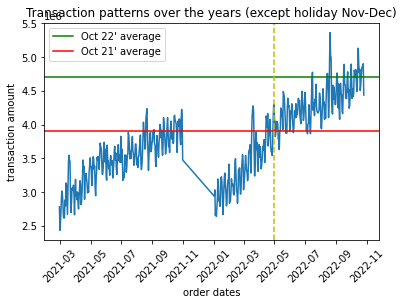

In [15]:
pattern_check = amount_per_day[(amount_per_day["order dates"] < "11-1-2021") | (amount_per_day["order dates"] >"1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=pattern_check)

oct_2011_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2021") & (amount_per_day["order dates"] < "11-1-2021")]["transaction amount"].mean()
oct_2022_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2022") & (amount_per_day["order dates"] < "11-1-2022")]["transaction amount"].mean()

plt.axhline(oct_2022_avg, color='g', label="Oct 22' average")
plt.axhline(oct_2011_avg, color='r', label="Oct 21' average")

plt.axvline(pd.to_datetime("5-1-2022"), color='y', linestyle="--")

plt.legend()
plt.title("Transaction patterns over the years (except holiday Nov-Dec)")

plt.xticks(rotation=45)
plt.show()

As seen in the graph, over the years of 21 and 22, there have been significant growth and fast paced recovery (considering a COVID effect on real-world like application). It is also important to note that there is a significant pattern in terms of purchasing power of customers. More of a deep dive is required to understand why it is an incresing trend every year rather than an overall increasing/linear trend

#### Special analysis of holiday season

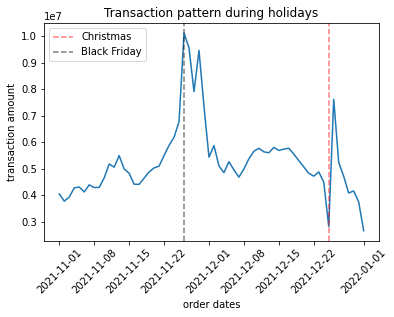

In [16]:
holiday_check = amount_per_day[(amount_per_day["order dates"] >= "11-1-2021") & (amount_per_day["order dates"] <= "1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=holiday_check)

plt.axvline(pd.to_datetime("12-25-2021"), color='r', linestyle="--", label="Christmas", alpha=0.5)
plt.axvline(pd.to_datetime("11-26-2021"), color='black', linestyle="--", label="Black Friday", alpha=0.5)

plt.title("Transaction pattern during holidays")
plt.legend()

plt.xticks(rotation=45)
plt.show()

#### Analysis of average transaction values

In [17]:
avg_per_day = transactions.groupBy("order_datetime").avg("dollar_value").toPandas()
avg_per_day.columns = ["Order dates", "Average value"]
avg_per_day["Order dates"] = pd.to_datetime(avg_per_day["Order dates"])
avg_per_day.sort_values(by="Order dates", inplace=True)

ERROR:root:KeyboardInterrupt while sending command.                (3 + 8) / 26]
Traceback (most recent call last):
  File "/home/ruitwang/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ruitwang/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

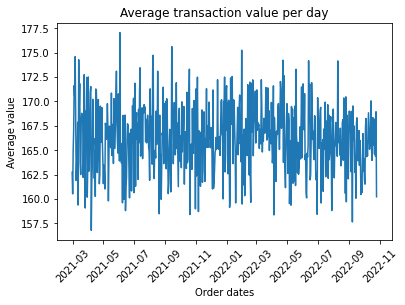

In [ ]:
sns.lineplot(x="Order dates", y="Average value", data=avg_per_day)

plt.title("Average transaction value per day")

plt.xticks(rotation=45)
plt.show()

As seen above, this is a fairly linear graph showing that the people still purchased items worth the same amount as they would during non-holiday periods

#### Group by day of week

In [ ]:
day_of_week = amount_per_day.groupby(amount_per_day["order dates"].dt.day_name()).mean()

In [ ]:
day_of_week.index

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object', name='order dates')

<AxesSubplot:xlabel='order dates', ylabel='transaction amount'>

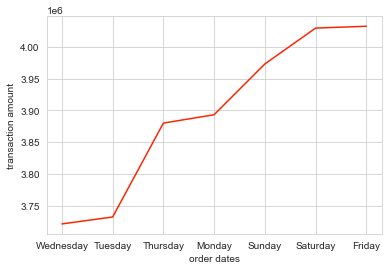

In [ ]:
sorted_day_of_week = day_of_week.sort_values(by="transaction amount")
sns.lineplot(data=sorted_day_of_week, x=sorted_day_of_week.index, y="transaction amount")

Huge number of transactions seen over Fri-Sun. Monday and Thursday being almost equal but subpar to the weekend. Tuesday and Wednesday being the least of all

### Public Holidays

In [9]:
from pyspark.sql.types import DateType

data = ['2021-03-08','2021-04-02','2021-04-03','2021-04-04','2021-04-05','2021-04-25','2021-06-14','2021-09-24','2021-11-02','2021-12-25','2021-12-26','2021-12-27','2021-12-28','2022-01-01','2022-01-03','2022-01-26','2022-03-14','2022-04-15','2022-04-16','2022-04-17','2022-04-18','2022-04-25','2022-06-13','2022-09-22','2022-09-23']
dates = pd.date_range(start='2021-02-01', end='2022-10-31')

list1 = []
for date in dates:
    _date = date.strftime('%Y-%m-%d')
    if _date in data:
        print(_date)
        list1.append((_date, 1))
    else:
        list1.append((_date, 0))
holiday_data = sp.createDataFrame(pd.DataFrame(list1, columns =['Date', 'holiday?']))
holiday_data = holiday_data.withColumn("Date",col("Date").cast(DateType()))

2021-03-08
2021-04-02
2021-04-03
2021-04-04
2021-04-05
2021-04-25
2021-06-14
2021-09-24
2021-11-02
2021-12-25
2021-12-26
2021-12-27
2021-12-28
2022-01-01
2022-01-03
2022-01-26
2022-03-14
2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-25
2022-06-13
2022-09-22
2022-09-23


In [10]:
holiday_data.show(3)

+----------+--------+
|      Date|holiday?|
+----------+--------+
|2021-02-01|       0|
|2021-02-02|       0|
|2021-02-03|       0|
+----------+--------+
only showing top 3 rows



In [11]:
holiday_data.count()

638

In [12]:
holiday_data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- holiday?: long (nullable = true)



In [19]:
holiday_fraud = holiday_data.join(cFraud, holiday_data.Date == cFraud.order_datetime).drop('order_datetime', 'user_id').toPandas()
holiday_fraud.head(5)

,Date,holiday?,fraud_probability
0,2021-02-28,0,10.815052
1,2021-02-28,0,9.689173
2,2021-02-28,0,9.802295
3,2021-02-28,0,10.447136
4,2021-02-28,0,9.131704


In [23]:
holiday_fraud['holiday?'].value_counts()

0    33199
1     1665
Name: holiday?, dtype: int64

In [24]:
normal_days = holiday_fraud.loc[holiday_fraud['holiday?']==0]
normal_days_sample = normal_days.sample(n=1665, random_state=111)

In [25]:
holiday_fraud_unbiased = pd.concat([normal_days_sample, holiday_fraud.loc[holiday_fraud['holiday?']==1]])

In [31]:
holiday_fraud_unbiased['holiday?'].value_counts()

0    1665
1    1665
Name: holiday?, dtype: int64

22/10/08 04:10:14 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 7205506 ms exceeds timeout 120000 ms
22/10/08 04:10:15 WARN SparkContext: Killing executors is not supported by current scheduler.


In [20]:
holiday_fraud.groupby('holiday?').mean('fraud_probability')

,fraud_probability
holiday?,
0,15.108109
1,15.359002


In [28]:
holiday_fraud_unbiased.groupby('holiday?').mean('fraud_probability')

,fraud_probability
holiday?,
0,15.319196
1,15.359002


In [21]:
holiday_fraud.groupby('holiday?').median('fraud_probability')

,fraud_probability
holiday?,
0,11.729142
1,11.924203


In [27]:
holiday_fraud_unbiased.groupby('holiday?').median('fraud_probability')

,fraud_probability
holiday?,
0,11.905342
1,11.924203


The mean and median are fairly similar for chances of fraud on public holidays vs normal days.

In [22]:
holiday_fraud['holiday?'].corr(holiday_fraud['fraud_probability'])

0.005379426048245172

In [29]:
holiday_fraud_unbiased['holiday?'].corr(holiday_fraud_unbiased['fraud_probability'])

0.002011067421660969

The Pearson's correlation coefficient is also very low, further strengthening the result that these two aren't really related.

### Parse the merchants' "tags"

In [ ]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [ ]:
merchants_pd = merchants.toPandas()

def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants_pd['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [ ]:
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))

merchant_tbl = pd.concat([merchants_pd, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns=['tags'], inplace=True)

In [ ]:
set(merchant_tbl['Description'])

{'antique shop sale repair restoration service',
 'art dealer gallery',
 'artist supply craft shop',
 'bicycle shop sale service',
 'book periodical newspaper',
 'cable satellite pay television radio service',
 'computer computer peripheral equipment software',
 'computer programming data processing integrated system design service',
 'digital good book movie music',
 'equipment tool furniture appliance rent al leasing',
 'florist supply nursery stock flower',
 'furniture home furnishing equipment shop manufacturer except appliance',
 'gift card novelty souvenir shop',
 'health beauty spa',
 'hobby toy game shop',
 'jewelry watch clock silverware shop',
 'lawn garden supply outlet including nursery',
 'motor vehicle supply new part',
 'music shop musical instrument piano sheet music',
 'optician optical good eyeglass',
 'shoe shop',
 'stationery office supply printing writing paper',
 'telecom',
 'tent awning shop',
 'watch clock jewelry repair shop'}

In [ ]:
merchant_tbl.to_csv("../data/curated/merchants_tbl_processed.csv")

In [ ]:
merchant_tbl = sp.read.option("header", True).csv("../data/curated/merchants_tbl_processed.csv").drop('_c0', 'name')
merchant_tbl.show(3)

+------------+--------------------+--------------+--------+
|merchant_abn|         Description|Earnings_Class|BNPL_Fee|
+------------+--------------------+--------------+--------+
| 10023283211|furniture home fu...|             e|    0.18|
| 10142254217|cable satellite p...|             b|    4.22|
| 10165489824|jewelry watch clo...|             b|     4.4|
+------------+--------------------+--------------+--------+
only showing top 3 rows



In [ ]:
merch_tran = transactions.join(merchant_tbl, on="merchant_abn")

check_class = merch_tran.groupBy("merchant_abn").sum("dollar_value").join(merchant_tbl, on="merchant_abn")
check_class.show(4)

+------------+-----------------+--------------------+--------------+--------+
|merchant_abn|sum(dollar_value)|         Description|Earnings_Class|BNPL_Fee|
+------------+-----------------+--------------------+--------------+--------+
| 38700038932|9546185.360697314|    tent awning shop|             a|    6.31|
| 83412691377|498536.5816973136|watch clock jewel...|             c|    2.94|
| 15613631617| 543030.531332826|motor vehicle sup...|             e|    0.35|
| 19839532017|         113982.0|cable satellite p...|             b|    4.94|
+------------+-----------------+--------------------+--------------+--------+
only showing top 4 rows



In [ ]:
check_class.groupBy("Earnings_Class").avg("sum(dollar_value)").show()
plot_class = check_class.toPandas()

+--------------+----------------------+
|Earnings_Class|avg(sum(dollar_value))|
+--------------+----------------------+
|             e|     466409.1137064723|
|             d|     380160.4808673627|
|             c|     492228.4833728333|
|             b|     572100.8022827655|
|             a|     542033.4187956803|
+--------------+----------------------+



<AxesSubplot:xlabel='BNPL_Fee', ylabel='take away revenue'>

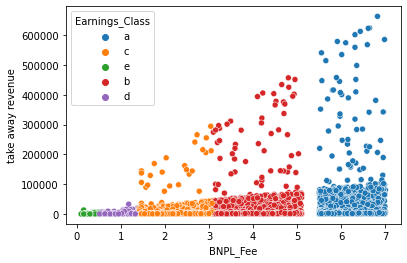

In [ ]:
plot_class["BNPL_Fee"] = pd.to_numeric(plot_class["BNPL_Fee"])
plot_class["take away revenue"] = plot_class["BNPL_Fee"] * plot_class["sum(dollar_value)"] / 100

sns.scatterplot(x="BNPL_Fee", y="take away revenue", hue="Earnings_Class", data=plot_class)

### Transaction Count Distribution

In [ ]:
pie_chart = transactions.groupBy("user_id").count().withColumnRenamed("count", "Num Trans").groupBy("Num Trans").count().toPandas()
pie_chart.sort_values(by="Num Trans", inplace=True)
pie_chart.count()

Num Trans    53
count        53
dtype: int64

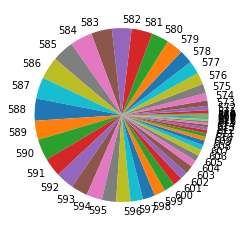

In [ ]:
plt.pie(x=pie_chart["count"], labels=pie_chart["Num Trans"])
plt.show()

<AxesSubplot:xlabel='Num Trans', ylabel='count'>

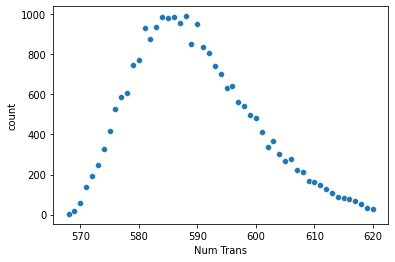

In [ ]:
sns.scatterplot(y="count", x="Num Trans", data=pie_chart)

#### Constant purchases with a dollar value of 157.0

In [ ]:
constant = transactions.filter(transactions.dollar_value == 157)

merchant_constant_pd = constant.groupBy("merchant_abn").count()
datetime_constant_pd = constant.groupBy("order_datetime").count().toPandas()
user_id_constant_pd = constant.groupBy("user_id").count().toPandas()

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("autumn")

In [ ]:
datetime_constant_pd["order_datetime"] = pd.to_datetime(datetime_constant_pd["order_datetime"])

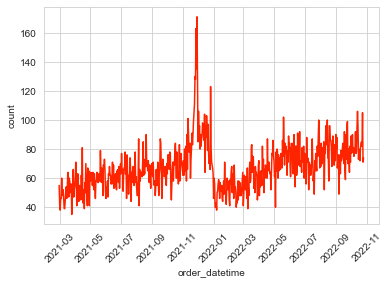

In [ ]:
sns.lineplot(x="order_datetime", y="count", data=datetime_constant_pd.sort_values(by="order_datetime"))

plt.xticks(rotation=45)
plt.show()

In [ ]:
merch_constant = merchant_constant_pd.join(merchant_tbl, ['merchant_abn'])

In [ ]:
merch_constant.select('Description').distinct().collect()

[Row(Description='cable satellite pay television radio service')]

All of these transactions belong to a single description, namely "cable satellite pay television radio service", which could be some kind of a periodic subscription service. Since this does not raise any concerns regarding the legitimacy of these transactions, we will include them in further analysis and modelling.

### Outlier detection for dollar value

In [ ]:
type(merchant_tbl)

pyspark.sql.dataframe.DataFrame

In [ ]:
full_dataset = transactions.join(customers, ['user_id'])
merchants_tbl = merchant_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [ ]:
full_dataset.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Earnings_Class: string (nullable = true)
 |-- BNPL_Fee: string (nullable = true)



In [ ]:
# add a day of the week, weekly & monthly attribute
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))

# round each dollar value to the nearest cent (not 5 cents, as there exists unusual pricing in the real world)
full_dataset = full_dataset.withColumn("dollar_value", F.round(F.col("dollar_value"), 2))

# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', 
                        (F.col('dollar_value') * 0.01 * F.col('BNPL_Fee')))

### Outlier detection algorithm
This will be inplemented by creating an attribute called 'potential outlier'. which marks dollar values of transactios that fall out of a companies specific SIQR as True, and False otherwise. Furthermore, it marks all transactions that belong to a company, which has no variance in the dollar value of respective transactios. This is due to it being unrealistic/dodgy.

In [ ]:
# use the SIQR range
# see https://towardsdatascience.com/outlier-detection-part-2-6839f6199768
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Second_percentile = F.expr('percentile_approx(dollar_value, 0.5)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'), Second_percentile.alias('2_val'), F.count('dollar_value').alias('Count'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Lower', F.col('2_val') - F.col('1_val'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Upper', F.col('3_val') - F.col('2_val'))

# Now calculate the limits
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 3 * F.col('SIQR_Upper'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 3 * F.col('SIQR_Lower'))

# after noticing that some merchants only have one transaction value (i.e one dollar_value amount for all transactios)
# decided to removed due to unrealisic distributed data 
quartile_dataset = quartile_dataset.withColumn('Natural_var', F.when((F.col('Upper_limit') == F.col('Lower_limit')) & (F.col('Count') > 10), True).otherwise(False))
quartile_dataset = quartile_dataset.select('merchant_abn', 'Upper_limit', 'Lower_limit', 'Natural_var')

In [ ]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [ ]:
# finally identify the outliers which fall out of distribution or apart of a dodgy business
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')) & (F.col('Natural_var') == False), False)
                                              .otherwise(True))

In [ ]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

[543.805s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 29.0 (TID 691): Retried waiting for GCLocker too often allocating 2097154 words
22/10/06 01:21:04 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
[544.041s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 29.0 (TID 693): Retried waiting for GCLocker too often allocating 2097154 words
22/10/06 01:21:05 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
[544.092s][warning][gc,alloc] Executor task launch worker for task 6.0 in stage 29.0 (TID 696): Retried waiting for GCLocker too often allocating 2097154 words
22/10/06 01:21:05 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
[544.119s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 29.0 (TID 690): Retried waiting for GCLocker too often allocating 2097154 words
22/10/06 01:21:05 WARN TaskMemoryManager: Failed to allocate a page (

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### Description analysis

In [ ]:
full_dataset.createOrReplaceTempView('data')
cFraud.createOrReplaceTempView('fraud')
dataset = sp.sql("""
select Description, avg(fraud_probability) as description_avg from data, fraud where (fraud.user_id == data.user_id) AND (fraud.order_datetime == data.order_datetime)
group by Description""")
dataset_pd = dataset.toPandas()

In [ ]:
tag_word = np.array([tag.split()[0] for tag in dataset_pd.Description])
df1 = pd.DataFrame(tag_word, dataset_pd.description_avg)

<AxesSubplot:xlabel='0', ylabel='description_avg'>

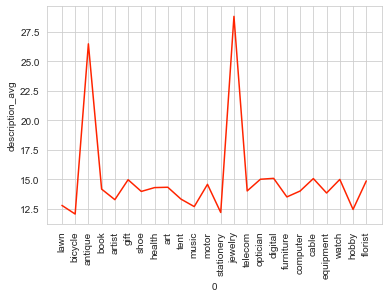

In [ ]:
plt.xticks(rotation=90)
sns.lineplot(x=df1[0], y=df1.index)


We can see from the above graph that jewellery companies have a higher average fraud probability followed by antique. Both of them are sectors with high dollar value. Fraud in such companies have been found in past literature (), and our analysis verifies the same.

In [ ]:
dataset.createOrReplaceTempView('fraud')
dataset = sp.sql("""
select * from data, fraud where fraud.Description == data.Description""")

In [ ]:
Administrative_Support_Services= ["equipment tool furniture appliance rent al leasing", "florist supply nursery stock flower", "lawn garden supply outlet including nursery"]

Personal_Services= ["shoe shop", "gift card novelty souvenir shop", "antique shop sale repair restoration service", "watch clock jewellery repair shop", "jewellery watch clock silverware shop",  "motor vehicle supply new part", "furniture home furnishing equipment shop manufa...", "tent awning shop", "optician optical good eyeglass"]

Arts_Recreation_Services = ["digital good book movie music", "music shop musical instrument piano sheet music", "health beauty spa", "bicycle shop sale service", "art dealer gallery", "hobby toy game shop", "stationery office supply printing writing paper"]

Information_Media_Telecommunications = ["telecom", "computer programming data processing integrated...", "book periodical newspaper", "artist supply craft shop", "computer computer peripheral equipment software", "cable satellite pay television radio service"]

desc = []
tags = []
for ele in Administrative_Support_Services:
    desc.append("Administrative_Support_Services")
tags += Administrative_Support_Services
for ele in Personal_Services:
    desc.append("Personal_Services")
tags += Personal_Services
for ele in Arts_Recreation_Services:
    desc.append("Arts_Recreation_Services")
tags += Arts_Recreation_Services
for ele in Information_Media_Telecommunications:
    desc.append("Information_Media_Telecommunications")
tags += Information_Media_Telecommunications

to_df = {
    "sector" :  desc,
    "Description" : tags
}
sectors = sp.createDataFrame(pd.DataFrame(to_df))
dataset_sect = dataset.join(sectors, ['Description'])
dataset_sect.createOrReplaceTempView('data')
dataset_sect_final = dataset_sect.join(sp.sql("""select sector, avg(description_avg) as sector_avg from data group by sector"""), ['sector'])

In [ ]:
sect_avg = sp.sql("""select sector, avg(description_avg) as sector_avg from data group by sector""")

22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on

<AxesSubplot:xlabel='sector', ylabel='sector_avg'>

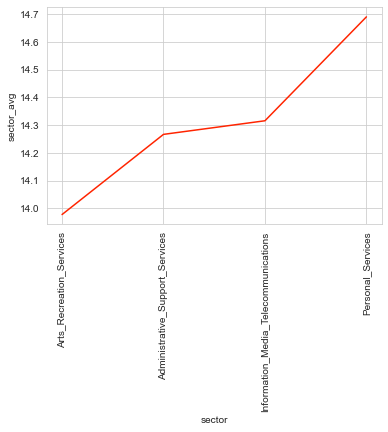

In [ ]:
sect_avg = sect_avg.toPandas()

plt.xticks(rotation=90)
sns.lineplot(x=sect_avg.sector, y=sect_avg.sector_avg)

Our analysis is futher supported by the graph above which shows personal services like antiques, watch and jewellery have higher chances of being fraud.

In [ ]:
sec_grouped = dataset_sect_final.groupBy("sector").sum("dollar_value")

In [ ]:
dataset_sect_final.count()

11561600

### Postcode Transaction analysis
The objective of this section is to verify if a customer's details have been recorded correctly

In [ ]:
dataset = sp.read.parquet('../data/curated/full_dataset/')

### Customer & Merchant fraud probabilities

In [ ]:
from pyspark.sql.types import DoubleType

cFraud = sp.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
cFraud = cFraud.withColumn("c_fraud_prob", col("fraud_probability").cast(DoubleType())).drop("fraud_probability")

mFraud = sp.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
mFraud = mFraud.withColumn("m_fraud_prob", col("fraud_probability").cast(DoubleType())).drop("fraud_probability")

Add merchant and customer fraud probabilities as new columns to transactions

In [ ]:
trans_mc = transactions.join(mFraud, ['merchant_abn', 'order_datetime']) 
trans_mc = trans_mc.join(cFraud, ['user_id', 'order_datetime']) 

In [ ]:
print("Number of rows after join: ", trans_mc.count())
trans_mc.show(3)

Number of rows after join:  440


+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
|user_id|order_datetime|merchant_abn|      dollar_value|            order_id|     m_fraud_prob|      c_fraud_prob|
+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
|   3101|    2021-04-17| 91880575299|105193.88578925544|2ab65c8f-11b2-41c...|32.99497823665355| 91.42192091901347|
|  19453|    2021-03-25| 83199298021|13887.358607198637|4d1ee9ac-2858-46d...|69.08556869902988|24.695211222609117|
|   2550|    2021-03-25| 83199298021| 37808.99908305577|bf73265f-fcd0-4f0...|69.08556869902988|55.876832987364644|
+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
only showing top 3 rows



In [ ]:
# compute avg customer fraud probabilities for each merchant
agg_probability = trans_mc \
    .groupBy('merchant_abn', 'm_fraud_prob', 'order_datetime') \
    .agg(F.mean('c_fraud_prob'), F.count('c_fraud_prob')) \
    .withColumnRenamed('avg(c_fraud_prob)', 'avg_cust_fraud') \
    .withColumnRenamed('count(c_fraud_prob)', 'cust_count')
agg_probability.show(5)

+------------+------------------+--------------+------------------+----------+
|merchant_abn|      m_fraud_prob|order_datetime|    avg_cust_fraud|cust_count|
+------------+------------------+--------------+------------------+----------+
| 91880575299| 32.99497823665355|    2021-04-17| 91.42192091901347|         1|
| 83199298021| 69.08556869902988|    2021-03-25|40.286022104986884|         2|
| 21439773999|28.504479048104585|    2021-11-26|16.901131702270927|        11|
| 43083074133| 48.66890735193894|    2021-12-18| 71.74055115445599|         3|
| 48534649627| 28.36052168812278|    2021-11-29|17.002857681418757|         6|
+------------+------------------+--------------+------------------+----------+
only showing top 5 rows



<AxesSubplot:xlabel='m_fraud_prob', ylabel='avg_cust_fraud'>

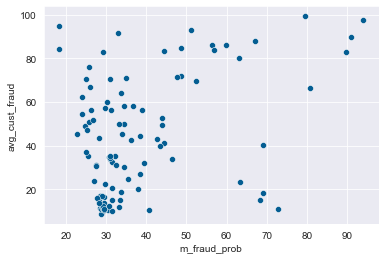

In [ ]:
pandas_df = agg_probability.toPandas()

sns.set_style("darkgrid")
sns.set_palette("PuBu_r")
sns.scatterplot(data=pandas_df, x='m_fraud_prob', y='avg_cust_fraud')

Analyse number of transactions made by fraudulent customers

In [ ]:
joined = cFraud.join(transactions, 
                    ["user_id", "order_datetime"])
joined.count()

80560

In [ ]:
pie_chart = joined.groupBy("user_id").count().withColumnRenamed("count", "Num Trans").groupBy("Num Trans").count().toPandas()
pie_chart.sort_values(by='Num Trans', inplace=True)

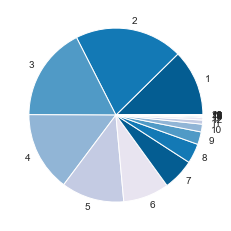

In [ ]:
plt.pie(x=pie_chart["count"], labels=pie_chart["Num Trans"])
plt.show()

### Transactions with unknown merchants

In [ ]:
print("Distinct merchants in the merchand fraud data:")
mFraud.select(countDistinct('merchant_abn')).show()

print("Distinct merchants in the transactions data:")
transactions.select(countDistinct('merchant_abn')).show()

print("Distinct merchants in merchant table:")
merchants.select(countDistinct('merchant_abn')).show()

Distinct merchants in the merchand fraud data:
+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                          61|
+----------------------------+

Distinct merchants in the transactions data:


+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4422|
+----------------------------+

Distinct merchants in merchant table:
+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4026|
+----------------------------+



In [ ]:
diff = transactions.select(col('merchant_abn')).subtract(merchants.select(col('merchant_abn')))
print("Total unidentified merchants: ", diff.count())

Total unidentified merchants:  396


In [ ]:
diff_list = diff.rdd.map(lambda x: x.merchant_abn).collect()
diff_df = transactions[transactions.merchant_abn.isin(diff_list)]

print("Transactions with unidentified merchants", diff_df.count())
print("Total dollar value of such transactions: ", diff_df.agg(F.sum("dollar_value")).collect()[0][0])

print("Average dollar value of such transactions: ", diff_df.agg(F.mean("dollar_value")).collect()[0][0])

diff_df.show(3)

Transactions with unidentified merchants 580830


Total dollar value of such transactions:  202648153.7429202


Average dollar value of such transactions:  348.89408905001494
+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|      8| 29566626791| 74.15732460440282|71a81652-cc91-4bf...|    2021-08-20|
|  18490| 32234779638|107.14809429376949|20149572-a55b-41f...|    2021-08-20|
|     20| 67202032418| 55.46394975814555|a29071b4-29b3-4f2...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 3 rows



In [6]:
tax_income = utils.read_tables(sp, "tax_income", "c")

In [26]:
tax_income.printSchema()
print(tax_income.count())
tax_df = tax_income.toPandas()

root
 |-- Postcode: integer (nullable = true)
 |-- Number of individuals lodging an income tax return: integer (nullable = true)
 |-- Count taxable income or loss: integer (nullable = true)
 |-- Average taxable income or loss: integer (nullable = true)
 |-- Median taxable income or loss: integer (nullable = true)
 |-- Proportion with salary or wages: double (nullable = true)
 |-- Count salary or wages: integer (nullable = true)
 |-- Average salary or wages: integer (nullable = true)
 |-- Median salary or wages: integer (nullable = true)
 |-- Proportion with net rent: double (nullable = true)
 |-- Count net rent: integer (nullable = true)
 |-- Average net rent: integer (nullable = true)
 |-- Median net rent: integer (nullable = true)
 |-- Count total income or loss: integer (nullable = true)
 |-- Average total income or loss: integer (nullable = true)
 |-- Median total income or loss: integer (nullable = true)
 |-- Count total deductions: integer (nullable = true)
 |-- Average total ded

<AxesSubplot:xlabel='Average total business income', ylabel='Count'>

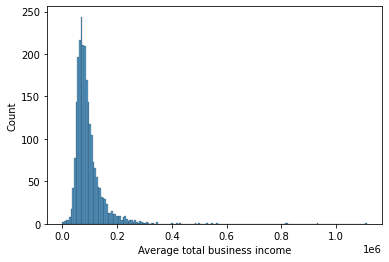

In [9]:
sns.histplot(data = tax_df, x = "Average total business income")

<AxesSubplot:xlabel='Median total business income', ylabel='Count'>

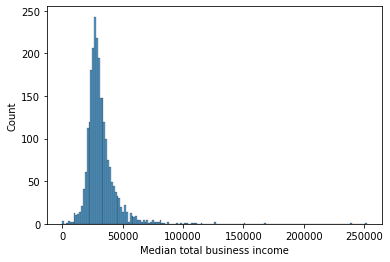

In [10]:
sns.histplot(data = tax_df, x = "Median total business income")

<AxesSubplot:xlabel='business_income_rate', ylabel='Count'>

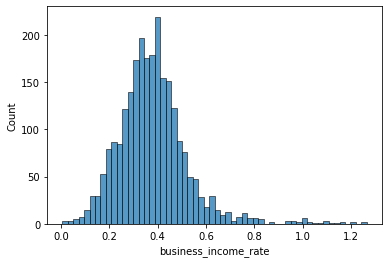

In [12]:
tax_df["business_income_rate"] = tax_df["Median total business income"] / tax_df["Average total business income"]
sns.histplot(data = tax_df, x = "business_income_rate")

In [17]:
tax_df[tax_df["Average total business income"]>400000]

,Postcode,Number of individuals lodging an income tax return,Count taxable income or loss,Average taxable income or loss,Median taxable income or loss,Proportion with salary or wages,Count salary or wages,Average salary or wages,Median salary or wages,Proportion with net rent,...,Average total business expenses,Median total business expenses,Proportion with net tax,Count net tax,Average net tax,Median net tax,Count super total accounts balance,Average super total accounts balance,Median super total accounts balance,business_income_rate
51,2030,9888,9888,186025,74350,0.64,6327,111863,61880,0.24,...,346121,17612,0.81,8023,83149,22416,10703,540049,84079,0.102754
429,2564,7147,7147,49257,44574,0.85,6043,53185,49570,0.11,...,1173535,12426,0.75,5360,12071,9110,8253,68072,25558,0.022795
773,3142,9970,9970,184939,70009,0.60,6002,99544,60000,0.18,...,446095,18300,0.80,7969,86102,21302,10711,860530,94537,0.077936
1023,3520,50,50,34839,29091,0.60,30,37487,34651,0.04,...,545194,82514,0.62,31,7083,6614,65,43488,22756,0.050736
1319,4007,10757,10757,107948,62321,0.77,8260,85285,62238,0.16,...,800340,10846,0.82,8800,41093,16255,11670,295660,66409,0.034128
1404,4163,9645,9645,72615,48117,0.73,7024,65650,52707,0.15,...,534521,10564,0.74,7132,25462,11964,10794,233375,81207,0.047151
1799,5090,4359,4359,49708,44981,0.75,3258,54887,51525,0.11,...,1003354,11672,0.74,3222,12289,9181,4745,119962,64455,0.026311
2124,6108,13519,13519,53312,45707,0.80,10844,58935,52914,0.12,...,486067,11768,0.74,9965,14455,10394,15548,96250,44376,0.057472
2244,6359,307,307,56992,45952,0.54,167,42002,39289,0.13,...,400004,17311,0.72,221,17665,11067,333,169809,31548,0.105417
2269,6423,93,93,51620,43363,0.63,59,59197,50240,0.15,...,499395,23870,0.70,65,16040,12193,102,112004,48315,0.032859


In [24]:
tax_df[tax_df["Median total business income"]>100000]

,Postcode,Number of individuals lodging an income tax return,Count taxable income or loss,Average taxable income or loss,Median taxable income or loss,Proportion with salary or wages,Count salary or wages,Average salary or wages,Median salary or wages,Proportion with net rent,...,Average total business expenses,Median total business expenses,Proportion with net tax,Count net tax,Average net tax,Median net tax,Count super total accounts balance,Average super total accounts balance,Median super total accounts balance,business_income_rate
541,2736,228,228,48862,36835,0.74,168,43144,35464,0.09,...,270972,89398,0.68,154,15417,7977,250,103595,33285,0.402373
582,2791,161,161,51342,41125,0.72,116,56081,47076,0.22,...,128182,99512,0.71,114,14563,9968,178,193728,83024,0.795381
1009,3491,79,79,63964,45958,0.63,50,32703,31812,0.16,...,338801,104414,0.71,56,21250,12380,78,96197,33749,0.483653
1066,3591,101,101,48369,40586,0.72,73,51879,46658,0.12,...,153611,139321,0.69,70,13429,8712,105,166473,78979,0.823841
1633,4713,243,243,45416,41326,0.88,214,44053,40958,0.01,...,292339,292339,0.73,177,9915,7135,400,30369,4978,1.000000
1898,5261,245,245,51066,38768,0.53,129,41254,34018,0.13,...,202682,66609,0.70,171,15353,9146,242,129738,51413,0.479569
1899,5262,322,322,56038,45341,0.62,199,44640,45182,0.12,...,236201,100776,0.74,237,17426,9482,320,137946,51061,0.473558
1993,5521,85,85,51534,40579,0.69,59,36604,31135,0.13,...,248848,132474,0.75,64,14126,8833,90,300088,59831,0.379249
2270,6425,88,88,80896,59985,0.55,48,32562,24496,0.27,...,172328,120238,0.77,68,27353,16039,96,84496,32313,0.943850
2332,6608,66,66,62070,53202,0.65,43,51199,48901,0.14,...,58803,58803,0.83,55,16585,12085,78,84074,26752,1.000000


In [23]:
tax_df[(tax_df["Median total business income"]>100000) & (tax_df["Average total business income"]>400000)] 

,Postcode,Number of individuals lodging an income tax return,Count taxable income or loss,Average taxable income or loss,Median taxable income or loss,Proportion with salary or wages,Count salary or wages,Average salary or wages,Median salary or wages,Proportion with net rent,...,Average total business expenses,Median total business expenses,Proportion with net tax,Count net tax,Average net tax,Median net tax,Count super total accounts balance,Average super total accounts balance,Median super total accounts balance,business_income_rate
